In [35]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.processor.accumulator import column_accumulator
from coffea.processor import accumulate
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

# Loading the exported dataset

In [40]:
df = load("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/output_ttHTobb_fullRun2_v1.coffea")

In [4]:
df["cutflow"]

{'initial': {'ttHTobb_2018': 9668000,
  'ttHTobb_2016_PreVFP': 4622000,
  'ttHTobb_2016_PostVFP': 4937000,
  'ttHTobb_2017': 7825000},
 'skim': {'ttHTobb_2018': 1606848,
  'ttHTobb_2016_PreVFP': 595171,
  'ttHTobb_2016_PostVFP': 665949,
  'ttHTobb_2017': 1239523},
 'presel': {'ttHTobb_2018': 762553,
  'ttHTobb_2016_PreVFP': 251905,
  'ttHTobb_2016_PostVFP': 289373,
  'ttHTobb_2017': 585451},
 'baseline': {'ttHTobb_2018': {'ttHTobb': 762553},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 251905},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 289373},
  'ttHTobb_2017': {'ttHTobb': 585451}},
 'semilep_LHE': {'ttHTobb_2018': {'ttHTobb': 569646},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 188931},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 217062},
  'ttHTobb_2017': {'ttHTobb': 438491}}}

In [5]:
df["sumw"]

{'baseline': {'ttHTobb_2018': {'ttHTobb': 1258.8333048318555},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 296.2494175097036},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 274.0572408013326},
  'ttHTobb_2017': {'ttHTobb': 856.4419132989669}},
 'semilep_LHE': {'ttHTobb_2018': {'ttHTobb': 929.3939145075354},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 220.62629025662434},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 204.17366224287653},
  'ttHTobb_2017': {'ttHTobb': 633.8371764421364}}}

### Normalize the genweights

In [41]:
datasets = df["sum_genweights"].keys()
print("Datasets: ", datasets)

Datasets:  dict_keys(['ttHTobb_2018', 'ttHTobb_2016_PreVFP', 'ttHTobb_2016_PostVFP', 'ttHTobb_2017'])


In [42]:
for dataset in datasets:
    df["columns"]["ttHTobb"][dataset]["semilep_LHE"]["weight"] = column_accumulator(df["columns"]["ttHTobb"][dataset]["semilep_LHE"]["weight"].value / df["sum_genweights"][dataset])

In [43]:
cs = accumulate([df["columns"]["ttHTobb"][dataset]["semilep_LHE"] for dataset in datasets])

partons = ak.unflatten(ak.zip({"pt": cs["Parton_pt"].value,
                              "eta": cs["Parton_eta"].value,
                              "phi": cs["Parton_phi"].value,
                               "mass": cs["Parton_mass"].value,
                              "pdgId": cs["Parton_pdgId"].value, 
                              "prov": cs["Parton_provenance"].value},
                         with_name='Momentum4D'),
                     cs["Parton_N"].value)

partons_matched = ak.unflatten(ak.zip({"pt": cs["PartonMatched_pt"].value,
                              "eta": cs["PartonMatched_eta"].value,
                              "phi": cs["PartonMatched_phi"].value,
                              "mass": cs["PartonMatched_mass"].value,
                              "pdgId": cs["PartonMatched_pdgId"].value, 
                              "prov": cs["PartonMatched_provenance"].value},
                         with_name='Momentum4D'),
                     cs["PartonMatched_N"].value)

jets = ak.unflatten(ak.zip({"pt": cs["JetGood_pt"].value,
                              "eta": cs["JetGood_eta"].value,
                              "phi": cs["JetGood_phi"].value,
                              "btag": cs["JetGood_btagDeepFlavB"].value,
                              "m": np.zeros(cs["JetGood_btagDeepFlavB"].value.shape)},
                         with_name='Momentum4D'),
                     cs["JetGood_N"].value)

jets_matched = ak.unflatten(ak.zip({"pt": cs["JetGoodMatched_pt"].value,
                              "eta": cs["JetGoodMatched_eta"].value,
                              "phi": cs["JetGoodMatched_phi"].value,
                              "btag": cs["JetGoodMatched_btagDeepFlavB"].value,
                              "prov": cs["PartonMatched_provenance"].value,
                              "m": np.zeros(cs["PartonMatched_provenance"].value.shape)},
                         with_name='Momentum4D'),
                     cs["JetGoodMatched_N"].value)


generator_info = ak.zip({"pdgid1": cs["Generator_id1"].value,
                              "pdgid2": cs["Generator_id2"].value,
                              "x1": cs["Generator_x1"].value,
                              "x2": cs["Generator_x2"].value},
                         )


lepton_partons = ak.unflatten(ak.zip({"pt": cs["LeptonParton_pt"].value,
                              "eta": cs["LeptonParton_eta"].value,
                              "phi": cs["LeptonParton_phi"].value,
                              "mass": cs["LeptonParton_mass"].value,
                              "pdgId": cs["LeptonParton_pdgId"].value},
                         with_name='Momentum4D'),
                     cs["LeptonParton_N"].value)


lepton = ak.zip({"pt": cs["LeptonGood_pt"].value,
                              "eta": cs["LeptonGood_eta"].value,
                              "phi": cs["LeptonGood_phi"].value,
                              "m": np.zeros(cs["LeptonGood_pt"].value.shape)},
                         with_name='Momentum4D')


met = ak.zip({"pt": cs["MET_pt"].value,
              "eta":  np.zeros(cs["MET_pt"].value.shape),
              "phi": cs["MET_phi"].value,
              "m": np.zeros(cs["MET_pt"].value.shape)},
         with_name='Momentum4D')

higgs = ak.zip({"pt": cs["HiggsParton_pt"].value,
                              "eta": cs["HiggsParton_eta"].value,
                              "phi": cs["HiggsParton_phi"].value,
                              "m": cs["HiggsParton_mass"].value},
                         with_name='Momentum4D')


In [48]:
jets_matched = ak.mask(jets_matched, jets_matched.pt==-999, None)
partons_matched = ak.mask(partons_matched, partons_matched.pt==-999, None)
is_jet_matched = ~ak.is_none(jets_matched, axis=1)
jets = ak.with_field(jets, is_jet_matched, "matched")

# Filling with -1 the not matched provenance
jets = ak.with_field(jets, ak.fill_none(jets_matched.prov, -1), "prov")

Jets and partons_matched arrays are **aligned**.

In [49]:
dfout = ak.zip({
    "jets": jets,
    "partons_matched": partons_matched,
    "partons": partons,
    "generator_info": generator_info,
    "lepton_partons":lepton_partons,
    "lepton_reco": lepton,
    "met": met,
    "higgs": higgs
    }, depth_limit=1)

ak.to_parquet(dfout, "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_fullRun2_v1.parquet")

#### Fully-matched dataset

In [62]:
N_matched_parton = ak.sum(~ak.is_none(partons_matched, axis=1), axis=1)
N_matched_parton_higgs =  ak.sum(partons_matched.prov == 1, axis=1)

(array([6.50000e+01, 1.49800e+03, 1.13960e+04, 7.83940e+04, 4.10335e+05,
        5.50934e+05, 3.03270e+05, 5.82380e+04]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <BarContainer object of 8 artists>)

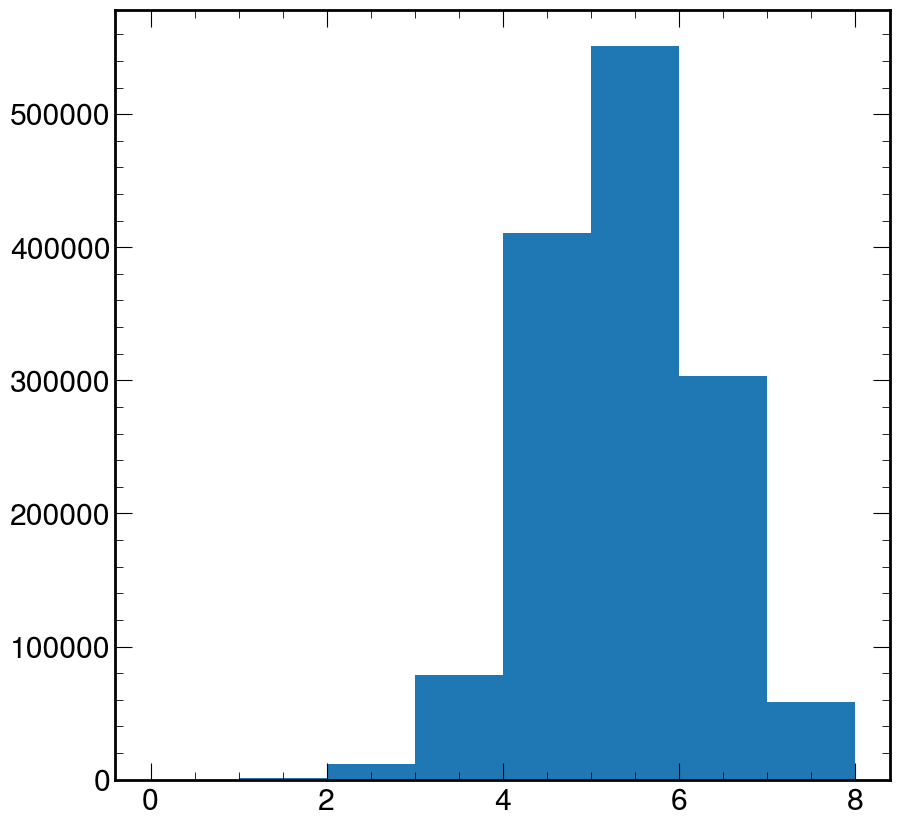

In [58]:
plt.hist(N_matched_parton, bins=8, range=(0, 8))

In [66]:
full_matched = (N_matched_parton == 7)
higgs_matched = N_matched_parton_higgs == 2

print(f"There are {ak.sum(full_matched)} fully matched events")
print(f"There are {ak.sum(higgs_matched)} events with fully matched higgs")

There are 58238 fully matched events
There are 850272 events with fully matched higgs


In [69]:
full_matched

<Array [False, False, False, ... False, False] type='1414130 * bool'>

In [70]:
dfout_full_matched = ak.zip({
    "jets": jets[full_matched],
    "partons_matched": partons_matched[full_matched],
    "partons": partons[full_matched],
    "generator_info": generator_info[full_matched],
    "lepton_partons":lepton_partons[full_matched],
    "lepton_reco": lepton[full_matched],
    "met": met[full_matched],
    "higgs": higgs[full_matched]
    }, depth_limit=1)

ak.to_parquet(dfout_full_matched, "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_fullypartonmatched_fullRun2_v1.parquet")

In [71]:
dfout_higgs_matched = ak.zip({
    "jets": jets[higgs_matched],
    "partons_matched": partons_matched[higgs_matched],
    "partons": partons[higgs_matched],
    "generator_info": generator_info[higgs_matched],
    "lepton_partons":lepton_partons[higgs_matched],
    "lepton_reco": lepton[higgs_matched],
    "met": met[higgs_matched],
    "higgs": higgs[higgs_matched]
    }, depth_limit=1)

ak.to_parquet(dfout_higgs_matched, "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_higgsmatched_fullRun2_v1.parquet")

In [16]:
# Now saving the "fully matched dataset", where all the events have all the partons matched

# Debugging plots

Text(1, 0, 'Events weight')

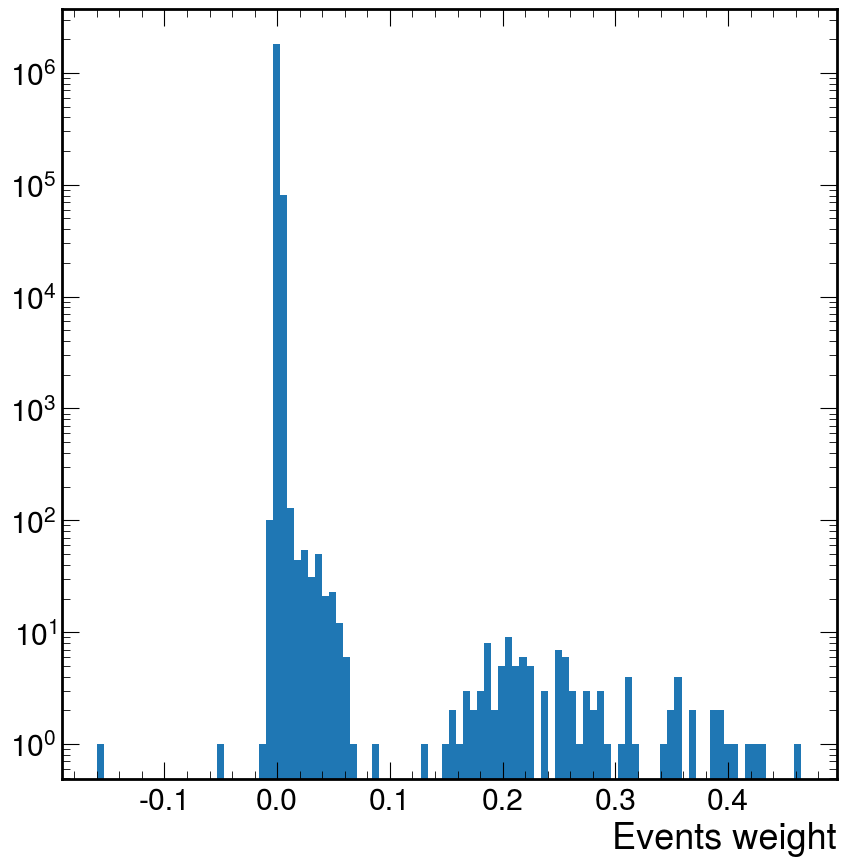

In [47]:
plt.hist(cs["weight"].value, bins=100)
plt.yscale("log")
plt.xlabel("Events weight")